In [ ]:
import zipfile
import os
import shutil
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from keras import backend as k
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten, Activation, BatchNormalization, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications import Xception
import cv2
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import glob
import random

In [ ]:
np.random.seed(99) 


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
drive_zip_file = "/content/drive/My Drive/bird_classification/bird_CUB_200_2011.zip"

extract_path = "/content/bird_data"

with zipfile.ZipFile(drive_zip_file, 'r') as zip_obj:
    # extract all the contents of the zip file to the specified directory
    zip_obj.extractall(extract_path)

In [ ]:
file_count = sum([len(files) for r, d, files in os.walk("/content/bird_data")])
print(file_count)

11801


In [ ]:
# open the file in read mode
# file_image = open('/content/bird_data/CUB_200_2011/images.txt', 'r')
# file_split = open('/content/bird_data/CUB_200_2011/train_test_split.txt', 'r')
# file_class = open('/content/bird_data/CUB_200_2011/image_class_labels.txt', 'r')

file_image = '/content/bird_data/CUB_200_2011/images.txt'
file_split = '/content/bird_data/CUB_200_2011/train_test_split.txt'
file_class = '/content/bird_data/CUB_200_2011/image_class_labels.txt'

# # read the contents of the file
# contents1 = file_image.read()
# #file_image.close()

# contents2 = file_split.read()
# #file_split.close()

# contents3 = file_class.read()
# #file_class.close()

# #print(contents1)

In [ ]:
# # specify the directory path where your image files are stored
# dir_path = "/content/bird_data/CUB_200_2011/images"

# # iterate over each subdirectory and its files
# for root, dirs, files in os.walk(dir_path):
#     for file in files:
#       # do something with the image file, such as displaying it or processing it
#       print("Processing image file:", os.path.join(root, file))

In [ ]:
# specify the path to the directory where you want to create the folders
dir_path = "/content/bird_data"

# specify the names of the folders you want to create
folder_name = "bird_split_dataset"
subfolder1_name = "train"
subfolder2_name = "test"

# join the directory path and folder names
folder_path = os.path.join(dir_path, folder_name)
subfolder1_path = os.path.join(folder_path, subfolder1_name)
subfolder2_path = os.path.join(folder_path, subfolder2_name)

# check if the folders exist, and create them if they don't
if not os.path.exists(folder_path):
    os.makedirs(subfolder1_path)
    os.makedirs(subfolder2_path)
    print("Folder and subfolders created:", folder_path)
else:
    print("Folder and subfolders already exist:", folder_path)

Folder and subfolders created: /content/bird_data/bird_split_dataset


In [ ]:
root_dir_path = "/content/bird_data/CUB_200_2011/images"

test_count = 0
train_count = 0

with open(file_image,'r') as image_info:
  with open(file_split,'r') as split_data:
    
    for read_img, read_split in zip(image_info, split_data):
      read_img = read_img.strip().split(' ')
      read_split = read_split.strip().split(' ')
      sub_dir=read_img[1].split('/')

      if read_img[0] == read_split[0]:
        if read_split[1] == '0':
          subfolder_path=os.path.join('/content/bird_data/bird_split_dataset/test',sub_dir[0])
          
          if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)
          
          path = os.path.join(root_dir_path, read_img[1])
          dest_path = os.path.join(subfolder_path, os.path.basename(path))
          shutil.move(path, dest_path)
          test_count += 1
        
        elif read_split[1] == '1':
          subfolder_path=os.path.join('/content/bird_data/bird_split_dataset/train',sub_dir[0])
          
          if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)

          path = os.path.join(root_dir_path, read_img[1])
          dest_path = os.path.join(subfolder_path, os.path.basename(path))
          shutil.move(path, dest_path)
          train_count += 1

print(f"Moved {test_count} images to test directory")
print(f"Moved {train_count} images to train directory")

Moved 5794 images to test directory
Moved 5994 images to train directory


In [ ]:
BATCH_SIZE = 32
EPOCHS = 20
INPUT_SIZE = [224, 224]

In [ ]:
data_path = '/content/bird_data/bird_split_dataset/'

# Create an ImageDataGenerator object for data augmentation
train_datagen = ImageDataGenerator(shear_range=0.1, 
                                  zoom_range=0.1, 
                                  horizontal_flip=True, 
                                  vertical_flip = True,
    
                                  validation_split=0.2  # split the data into training and validation sets
)

# Create a data generator for the training set
train_generator = train_datagen.flow_from_directory(
    '/content/bird_data/bird_split_dataset/train',
    target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    seed = 99,
    shuffle = True,
    class_mode='categorical',
    subset='training'  # use the training subset of the data
)

# Create a data generator for the validation set
validation_generator = train_datagen.flow_from_directory(
    '/content/bird_data/bird_split_dataset/train',
    target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    seed = 99,
    shuffle = False,
    class_mode='categorical',
    subset='validation'  # use the validation subset of the data
)

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('/content/bird_data/bird_split_dataset/test',
    target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    seed = 99,
    class_mode='categorical',
    shuffle=False  # don't shuffle the data for evaluation
)

train_images = len(train_generator.filenames)
print(f'***Train image count = ***', train_images)

# print some summary information about the generators
print("Training set:")
print("Number of batches =", len(train_generator))
print("Number of images =", len(train_generator.filenames))
print()

print("Validation set:")
print("Number of batches =", len(validation_generator))
print("Number of images =", len(validation_generator.filenames))
print()

print("Test set:")
print("Number of batches =", len(test_generator))
print("Number of images =", len(test_generator.filenames))

Found 4800 images belonging to 200 classes.
Found 1194 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.
***Train image count = *** 4800
Training set:
Number of batches = 150
Number of images = 4800

Validation set:
Number of batches = 38
Number of images = 1194

Test set:
Number of batches = 182
Number of images = 5794


In [ ]:
# img = cv2.imread(f"/content/bird_data/bird_split_dataset/train{[99]}")
# #plt.imshow(img)

In [ ]:
input_shape = INPUT_SIZE+[3]
input = Input(shape=input_shape)

In [ ]:
# network architecture...
def network(base_model, input):
    
    # Removes the values in the graph(network connections) but do not delete the graph itself... helps in RAM cleaning...
    tf.keras.backend.clear_session() 

    # Making Base model layers as non-trainable...
    for i in base_model.layers[:-15]:
        i.trainable=True

    input_layer = base_model(input, training=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(256, activation = 'relu'))
    model.add(Activation('relu'))
    model.add(Dense(200)) 
    model.add(Activation('softmax'))
    
    return model

In [ ]:
print(train_images)

5400


In [ ]:
# Loading weights of the InceptionV3 pre-trained model without including top layers... 
# imagenet is a dataset on which InceptionV3 was trained...
inception_model = InceptionV3(input_tensor = input, include_top=False, weights="imagenet")

incepV3_model = network(inception_model, input)

from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import math
def lr_schedule(epoch):
    lr = 0.1
    if epoch > 6:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


adam = Adam(lr=0.0001) # ADAM optimizer was used to reach the optimal weights...
incepV3_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) #, tfa.metrics.F1Score(200)])

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)



In [ ]:
incepV3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               51400     
                                                                 
 activation_1 (Activation)   (None, 200)               0

In [ ]:
# Fitting/training model...
incepV3_model.history = incepV3_model.fit(
    train_generator, 
    steps_per_epoch = train_images / 32, # number of steps in each epoch...
    callbacks=[ModelCheckpoint(filepath="/content/drive/MyDrive/language_model/model_weights_bestbirdfinal_diff2.h5", verbose=2, save_best_only=True), early_stop],
    epochs = 50, 
    validation_data = validation_generator)

In [ ]:
# Loading weights of the InceptionV3 pre-trained model without including top layers... 
# imagenet is a dataset on which InceptionV3 was trained...
Xception_model = Xception(input_tensor = input, include_top=False, weights="imagenet")

Xcep_model = network(Xception_model, input)

from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import math
def lr_schedule(epoch):
    lr = 0.1
    if epoch > 5:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


adam = Adam(lr=0.0001) # ADAM optimizer was used to reach the optimal weights...
Xcep_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) #, tfa.metrics.F1Score(200)])

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)



In [ ]:
# Fitting/training model...
Xcep_model.history = Xcep_model.fit(
    train_generator, 
    steps_per_epoch = train_images / 32, # number of steps in each epoch...
    callbacks=[ModelCheckpoint(filepath="/content/drive/MyDrive/language_model/model_weights_bestbirdfinal_diff3.h5", verbose=2, save_best_only=True), early_stop],
    epochs = 50, 
    validation_data = validation_generator)

Epoch 1/50
169/168 [==============================] - ETA: 0s - loss: 4.4041 - accuracy: 0.1343
Epoch 1: val_loss improved from inf to 2.76163, saving model to /content/drive/MyDrive/language_model/model_weights_bestbirdfinal_diff3.h5
168/168 [==============================] - 41s 207ms/step - loss: 4.4041 - accuracy: 0.1343 - val_loss: 2.7616 - val_accuracy: 0.3586
Epoch 2/50
169/168 [==============================] - ETA: 0s - loss: 1.4811 - accuracy: 0.6226
Epoch 2: val_loss improved from 2.76163 to 1.94536, saving model to /content/drive/MyDrive/language_model/model_weights_bestbirdfinal_diff3.h5
168/168 [==============================] - 36s 211ms/step - loss: 1.4811 - accuracy: 0.6226 - val_loss: 1.9454 - val_accuracy: 0.5135
Epoch 3/50
169/168 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.9222
Epoch 3: val_loss improved from 1.94536 to 1.91071, saving model to /content/drive/MyDrive/language_model/model_weights_bestbirdfinal_diff3.h5
168/168 [==========

In [ ]:
resnet_model = ResNet101(input_tensor = input, include_top=False, weights="imagenet")

res_model = network(resnet_model, input)

adam = Adam(learning_rate=0.0001) # ADAM optimizer was used to reach the optimal weights...
res_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) #, tfa.metrics.F1Score(375)])


# Fitting/training model...
res_history = res_model.fit(
    train_generator, 
    steps_per_epoch = train_images / 32, # number of steps in each epoch...
    callbacks=[ModelCheckpoint(filepath="/content/drive/MyDrive/language_model/model_weights_bestbirdfinal_diff4.h5", verbose=2, save_best_only=True), early_stop],
    epochs = 50, 
    validation_data = validation_generator)

###**MODEL EVALUATION**

In [ ]:
# load the saved model
incepV3_model = load_model('/content/drive/MyDrive/bird_classification/birdv3.h5')
incepV3_model_results = incepV3_model.evaluate(test_generator)

182/182 [==============================] - 31s 165ms/step - loss: 1.9944 - accuracy: 0.6369


In [ ]:
y_pred = incepV3_model.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

182/182 [==============================] - 31s 168ms/step


In [ ]:
accuracy = accuracy_score(test_generator.classes,y_pred)

In [ ]:
print(accuracy)

0.6368657231618916


In [ ]:
# finding the test accuracy
accuracy = accuracy_score(test_generator.classes,y_pred)
# calculating the f1 score
f1_score_val = f1_score(test_generator.classes, y_pred, average='weighted')
# calculating the precision
precision_score_val = precision_score(test_generator.classes,y_pred,average='weighted')
# calculating the recall_score
recall_score_val = recall_score(test_generator.classes,y_pred,average='weighted')

In [ ]:
confusion_mat = confusion_matrix(test_generator.classes, y_pred)


Model Results:
 
      Accuracy: 0.637
 
      F1 Score:0.636
 
      Precision Score: 0.673
 
      Recall Score: 0.637



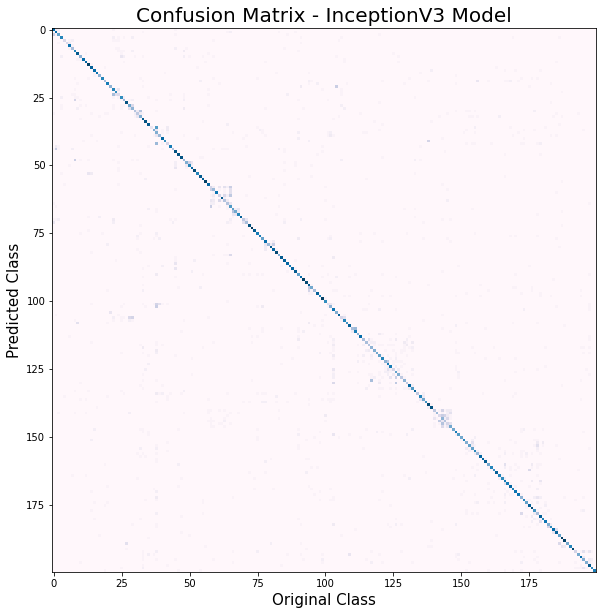

In [ ]:
print(f'''Model Results:\n 
      Accuracy: {round(accuracy,3)}\n 
      F1 Score:{round(f1_score_val,3)}\n 
      Precision Score: {round(precision_score_val,3)}\n 
      Recall Score: {round(recall_score_val,3)}\n''')

plt.figure(figsize=(10,10))
plt.imshow(confusion_mat, cmap='PuBu', interpolation='nearest')
plt.title("Confusion Matrix - InceptionV3 Model", fontsize = 20)
plt.xlabel("Original Class", fontsize = 15)
plt.ylabel("Predicted Class", fontsize = 15)
plt.show()